goal is to obtain butenedial decay rates as a function of pH

In [1]:
import os
notebook_wd = os.getcwd()
notebook_wd

'C:\\Users\\joh3146\\Documents\\pyrosolchem\\notebooks'

In [2]:
os.chdir(os.path.join(notebook_wd, '..'))

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from src.d00_utils.conf_utils import *
from src.d00_utils.data_utils import *
from src.d00_utils.plotting_utils import *

In [5]:
csv_file_dir = os.path.join(notebook_wd, '..', 'data', '20200109_butenedial_decay.csv')
df = pd.read_csv(csv_file_dir)
df.head()

,sample,pH_est,t_mix,t_ nmr,t_elapsed,bd_sig_norm
0,bd_ph9.6_d2o_001,9.6,11:31,11:34:30,0:03:30,6.86
1,bd_ph9.6_d2o_001,9.6,11:31,11:39,0:08:00,6.43
2,bd_ph9.6_d2o_001,9.6,11:31,11:42:30,0:11:30,5.85
3,bd_ph9.6_d2o_001,9.6,11:31,11:46:30,0:15:30,5.35
4,bd_ph9.6_d2o_001,9.6,11:31,11:50,0:19:00,4.71


have the right file name, now perform a simple plot to look at the data.

In [51]:
# need to fix the time column to plot
df['t'] = df['t_elapsed'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]) + int(x[2]) / 60)
df.t.head()

0     3.5
1     8.0
2    11.5
3    15.5
4    19.0
Name: t_elapsed, dtype: float64

Text(0, 0.5, 'normalized butenedial signal')

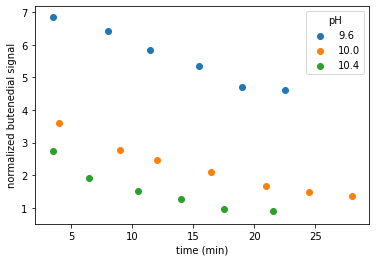

In [52]:
pHs = df.pH_est.unique()
N_sample = len(pHs)

fig, ax = plt.subplots(1,1)

for tick in range(N_sample):
    df_sub = df[df.pH_est == pHs[tick]]
    
    ax.scatter(df_sub.t, df_sub.bd_sig_norm, label=pHs[tick])
    
ax.legend(title='pH')
ax.set_xlabel('time (min)')
ax.set_ylabel('normalized butenedial signal')

notes: they should all start from the same signal (since the butenedial and dms molarity should have remained constant through experiments); looks somewhat exponential (can we assume that the pH remains roughly constant?? and if not, what does that say about the shapes of the lines and how they should be fit?)


for now i'll assume that ph is constant and extract first order rate terms. the ph can probably more accurately been taken with acetic acid shifts and then applied with the disproportionation function (see below).

In [55]:
df['ln_sig'] = np.log(df.bd_sig_norm)
df.ln_sig.head()

0    1.925707
1    1.860975
2    1.766442
3    1.677097
4    1.549688
Name: ln_sig, dtype: float64

Text(0, 0.5, 'log(normalized butenedial signal)')

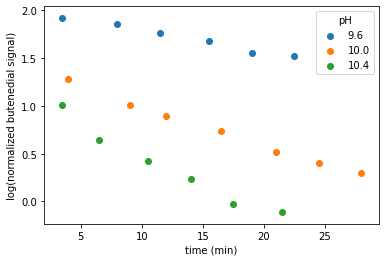

In [56]:
pHs = df.pH_est.unique()
N_sample = len(pHs)

fig, ax = plt.subplots(1,1)

for tick in range(N_sample):
    df_sub = df[df.pH_est == pHs[tick]]
    
    ax.scatter(df_sub.t, df_sub.ln_sig, label=pHs[tick])
    
ax.legend(title='pH')
ax.set_xlabel('time (min)')
ax.set_ylabel('log(normalized butenedial signal)')

looks approximately linear, but again, they should be going through the same y-intercept. i can only assume that there is a big ph shift in the beginning for the faster reactions.

perform linear regression with sklearn on the log data.

In [64]:
from src.d01_data.perform_ols import *
from sklearn.linear_model import LinearRegression

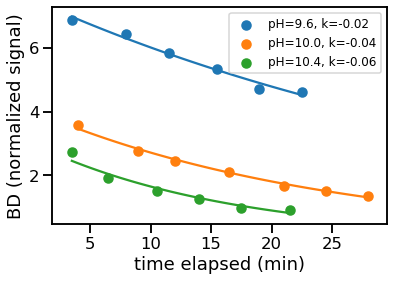

In [95]:
fig, ax = plt.subplots()

sns.set_context('talk')

for tick in range(N_sample):
    df_sub = df[df.pH_est == pHs[tick]]
    
    x_data = df_sub[df_sub.pH_est == pHs[tick]].t.values.reshape(-1, 1)
    y_data = df_sub[df_sub.pH_est == pHs[tick]].ln_sig.values

    b0, b1, score = perform_regression(x_data, y_data)
    xs, lnyhats = generate_linear_data(x_data, b0, b1)
    yhats = np.exp(lnyhats)

    label = 'pH=' + str(pHs[tick]) + ', k=' + str(b1[0])[0:5]
    ax.scatter(df_sub.t, df_sub.bd_sig_norm, label=label)
    ax.plot(xs, yhats)
    
ax.legend(prop={'size': 12})
ax.set_xlabel('time elapsed (min)')
ax.set_ylabel('BD (normalized signal)');

for later: a starting place for the disproportionation functions

In [53]:
def disproportionation_fn(y, t, coefs):
    """
    Your system of differential equations
    """

    B = y[0]

    a0 = coefs['a0'].value
    a1 = coefs['a1'].value
    a2 = coefs['a2'].value
    
    OH_minus = 10**(-9.6)
    
    # the model equation (franske & reilly, 1986)
    dBdt = (a0 * OH_minus + a2 * (OH_minus**2) * B) / (1 + a3 * OH_minus)
    
    return [dBdt]

In [ ]:
def g(t, y0, coefs):
    """
    Solution to the ODE y'(t) = f(t,y,k) with initial condition y0
    """
    
    y = odeint(droplet_function, y0, t, args=(coefs,))
    
    return y

In [ ]:
def residual(coefs, t, data):
    """
    compute the residual between actual data and fitted data
    """

    y0 = coefs['B_0'].value
    model = g(t, y0, coefs).T

    return (model - data).ravel()

In [ ]:
B_0 = 0.033
P_0 = D_0 = 0
X_0 = [B_0, P_0, D_0]

params = Parameters()
params.add('B_0', value=B_0, vary=False)
params.add('k0', value=5, min=0, max=10.)
params.add('k1', value=5, min=0, max=10.)
params.add('k_LD', value=3.5, min=0, max=2.)
params.add('a', value=5, min=0.0001, max=20.)
params.add('b', value=3.5, min=0.0001, max=20.)

In [ ]:
ys = np.array([df_processed.mz85_mz283.values, df_processed.mz84_mz283.values, df_processed.mz149_mz283.values])

In [ ]:
result = minimize(residual, params, args=(df_processed.mins.values, ys), method='leastsq')
result

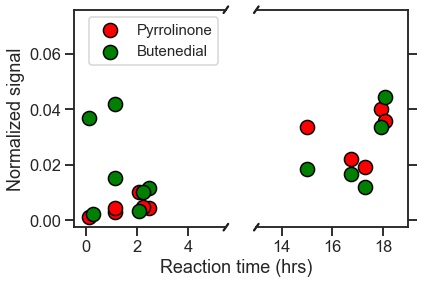

In [7]:
from src.d05_reporting.plot_ms_data import *

series_labels = [['Pyrrolinone', 'Butenedial']]
series_colors = [['red', 'green']]

ax = plot_ms_data_with_break(experiments_dict=bd_as_expts, x_col_name='hrs', 
                                     y_col_names=['mz84_mz283', 'mz85_mz283'],
                                     series_labels=series_labels, series_colors=series_colors,
                                     x_label='Reaction time (hrs)', y_label='Normalized signal',
                                     left_xlims=[-0.5, 5.5], right_xlims=[13, 19],
                                     series_title=None, save_fig=True)

now consider ammonium hydroxide experiments

In [8]:
bd_ah_expts = load_experiments(['bd_rxn_nh4oh_vial'])
bd_ah_expts.keys()

dict_keys(['bd_rxn_nh4oh_vial'])

In [9]:
bd_ah_file_name = bd_ah_expts['bd_rxn_nh4oh_vial']['paths']['raw_data']
df_bd_ah = import_ms_data(bd_ah_file_name)
df_bd_ah.columns

Index(['path', 'p283', 'p84', 'p85', 'p112', 'p122', 'p149', 'p150', 'p168',
       'file', 'date', 'n84', 'n85', 'vial', 'nhx', 'Unnamed: 15'],
      dtype='object')

explore the dataset

In [10]:
nhx = df_bd_ah.nhx.unique()
nhx = np.sort(nhx)
nhx

array([0.16, 0.32, 0.65])

Text(0, 0.5, 'normalized signal')

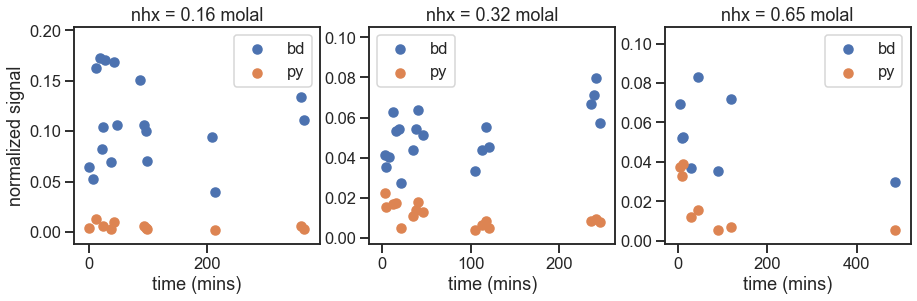

In [11]:
fig, ax = plt.subplots(1, len(nhx), figsize=(15,4))

for tick in range(len(nhx)):
    df_to_plot = df_bd_ah[df_bd_ah.nhx == nhx[tick]]
    ax[tick].scatter(df_to_plot.vial, df_to_plot.n85, label='bd')
    ax[tick].scatter(df_to_plot.vial, df_to_plot.n84, label='py')
    title_string = 'nhx = ' + str(nhx[tick]) + ' molal'
    ax[tick].set_title(title_string)
    ax[tick].legend()
    ax[tick].set_xlabel('time (mins)')

ax[0].set_ylabel('normalized signal')

In [12]:
df_bd_ah['n112'] = df_bd_ah['p112'] / df_bd_ah['p283']
df_bd_ah['n122'] = df_bd_ah['p122'] / df_bd_ah['p283']
df_bd_ah['n149'] = df_bd_ah['p149'] / df_bd_ah['p283']
df_bd_ah['n150'] = df_bd_ah['p150'] / df_bd_ah['p283']
df_bd_ah['n168'] = df_bd_ah['p168'] / df_bd_ah['p283']

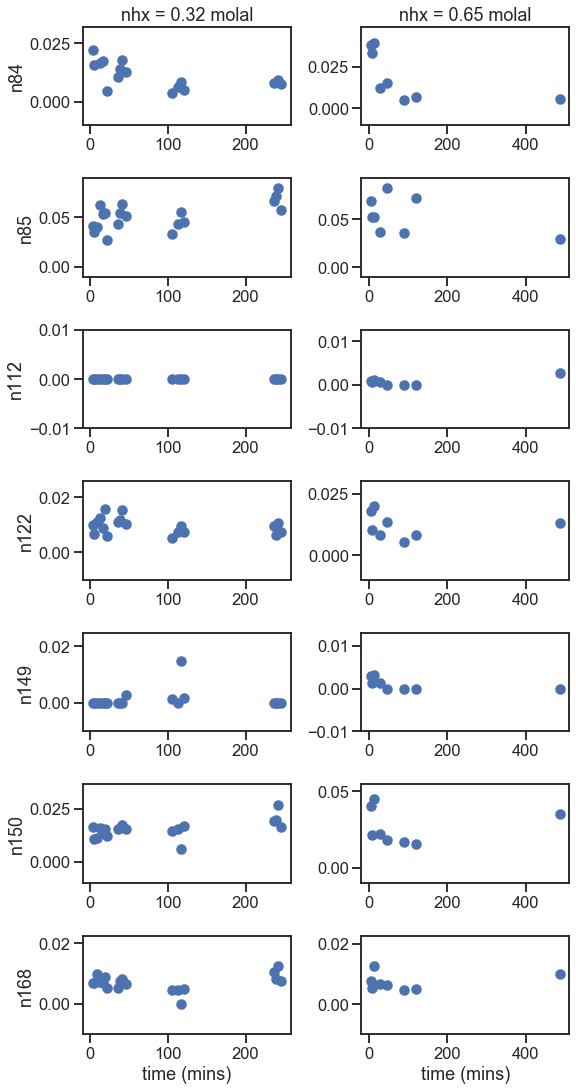

In [33]:
nhx_to_plot = [0.32, 0.65]
species_to_plot = ['n84', 'n85', 'n112', 'n122', 'n149', 'n150', 'n168']
num_species = len(species_to_plot)

fig, ax = plt.subplots(num_species, 2, figsize=(8, 15))
fig.tight_layout()

for tock in range(2):
    df_to_plot = df_bd_ah[df_bd_ah.nhx == nhx_to_plot[tock]]

    for tick in range(num_species):
        species = species_to_plot[tick]
        maxval = np.max(df_to_plot[species])
        ax[tick, tock].scatter(df_to_plot.vial, df_to_plot[species], label=species)
        title_string = 'nhx = ' + str(nhx_to_plot[tock]) + ' molal'
        ax[tick, 0].set_ylabel(species)
        ax[tick, tock].set_ylim(ymin=-0.01, ymax=maxval+0.01)

    ax[0, tock].set_title(title_string)
    ax[num_species-1, tock].set_xlabel('time (mins)')

now want to look at the measurements taken last two weeks, with buffered solution

In [14]:
bd_as_buff_expts = load_experiments(['bd_rxn_nh42so4_buffer_vial'])
bd_as_buff_expts.keys()

dict_keys(['bd_rxn_nh42so4_buffer_vial'])

In [15]:
bd_as_buff_file_name = bd_as_buff_expts['bd_rxn_nh42so4_buffer_vial']['paths']['raw_data']
df_bd_as_buff = import_ms_data(bd_as_buff_file_name)
df_bd_as_buff.columns

Index(['date', 'data', 'data_start_time', 'chrom', 'sol_id', 'rxn_start_time',
       'peak_record_time', 'rxn_time', 'mz84', 'mz85', 'mz112', 'mz122',
       'mz150', 'mz168', 'mz283', 'notes'],
      dtype='object')

In [16]:
df_bd_as_buff.drop([0, 39], inplace=True)

In [17]:
df_bd_as_buff['mz84_mz283'] = df_bd_as_buff['mz84'] / df_bd_as_buff['mz283']
df_bd_as_buff['mz85_mz283'] = df_bd_as_buff['mz85'] / df_bd_as_buff['mz283']
df_bd_as_buff['mz112_mz283'] = df_bd_as_buff['mz112'] / df_bd_as_buff['mz283']
df_bd_as_buff['mz122_mz283'] = df_bd_as_buff['mz122'] / df_bd_as_buff['mz283']
df_bd_as_buff['mz150_mz283'] = df_bd_as_buff['mz150'] / df_bd_as_buff['mz283']
df_bd_as_buff['mz168_mz283'] = df_bd_as_buff['mz168'] / df_bd_as_buff['mz283']

In [18]:
df_bd_as_buff['mins'] = pd.to_timedelta(df_bd_as_buff.rxn_time).dt.total_seconds()/60
df_bd_as_buff['mins'] = df_bd_as_buff['mins'].astype(int)
df_bd_as_buff['mins'].head()

1     2
2     5
3     7
4    11
5    14
Name: mins, dtype: int32

In [19]:
expt_names = ['bd_as_001', 'bd_as_002']
nh3 = [0.1, 0.5]

Text(0, 0.5, 'normalized signal')

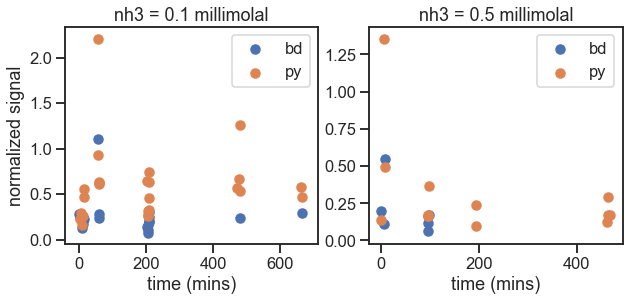

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

for tick in range(2):
    expt_name = expt_names[tick]
    df_to_plot = df_bd_as_buff[df_bd_as_buff.sol_id == expt_name]
    ax[tick].scatter(df_to_plot.mins[df_to_plot.mz85_mz283 > 0], df_to_plot.mz85_mz283[df_to_plot.mz85_mz283 > 0], 
                     label='bd')
    ax[tick].scatter(df_to_plot.mins[df_to_plot.mz84_mz283 > 0], df_to_plot.mz84_mz283[df_to_plot.mz84_mz283 > 0], 
                     label='py')
    title_string = 'nh3 = ' + str(nh3[tick]) + ' millimolal'
    ax[tick].set_title(title_string)
    ax[tick].legend()
    ax[tick].set_xlabel('time (mins)')

ax[0].set_ylabel('normalized signal')

In [21]:
ac_expt_names = ['bd_ac_001', 'bd_ac_002']
species_names_to_plot = ['mz84_mz283', 'mz85_mz283', 'mz112_mz283', 'mz122_mz283', 'mz150_mz283', 'mz168_mz283']
num_species = len(species_names_to_plot)
nh3 = [0.1, 3]

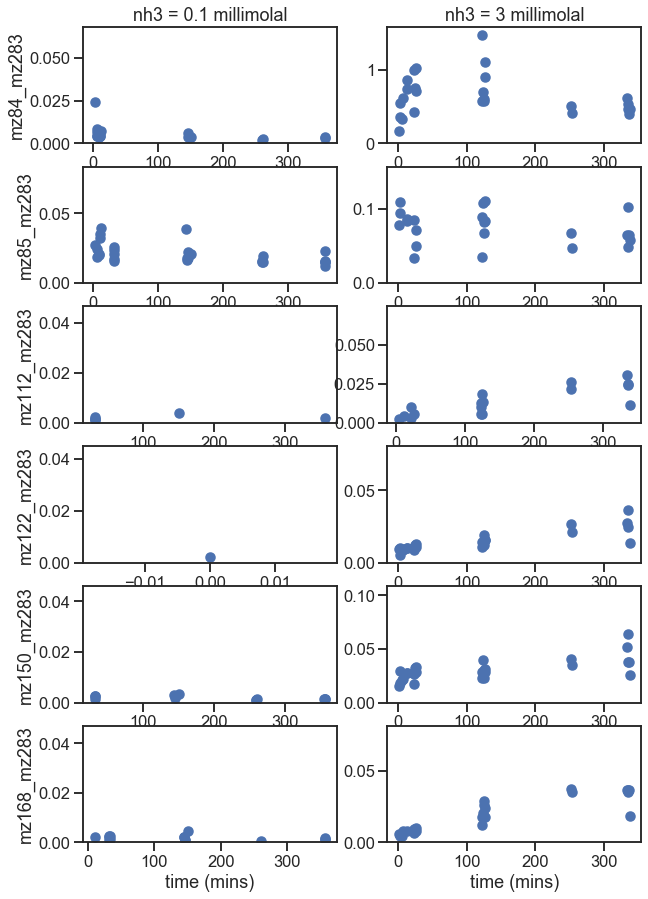

In [22]:
fig, ax = plt.subplots(num_species, 2, figsize=(10,15))

for tick in range(num_species):
    df_to_plot_001 = df_bd_as_buff[df_bd_as_buff.sol_id == 'bd_ac_001']
    df_to_plot_002 = df_bd_as_buff[df_bd_as_buff.sol_id == 'bd_ac_002']
    
    species = species_names_to_plot[tick]
    ax[tick, 0].scatter(df_to_plot_001.mins[df_to_plot_001[species] > 0], df_to_plot_001[species][df_to_plot_001[species] > 0],
                        label=species)
    ax[tick, 1].scatter(df_to_plot_002.mins[df_to_plot_002[species] > 0], df_to_plot_002[species][df_to_plot_002[species] > 0],
                        label=species)
    ax[tick, 0].set_ylabel(species)
    ax[tick, 0].set_ylim(ymin=0)
    ax[tick, 1].set_ylim(ymin=0)

for tick in range(len(nh3)):    
    title_string = 'nh3 = ' + str(nh3[tick]) + ' millimolal'
    ax[0, tick].set_title(title_string)
    ax[5, tick].set_xlabel('time (mins)')

looks like 112, 122, 150, 168 all have the same shape?
look at correlation.

In [23]:
species_names_to_correlate = ['mz112_mz283', 'mz122_mz283', 'mz150_mz283', 'mz168_mz283']
num_species = len(species_names_to_correlate)

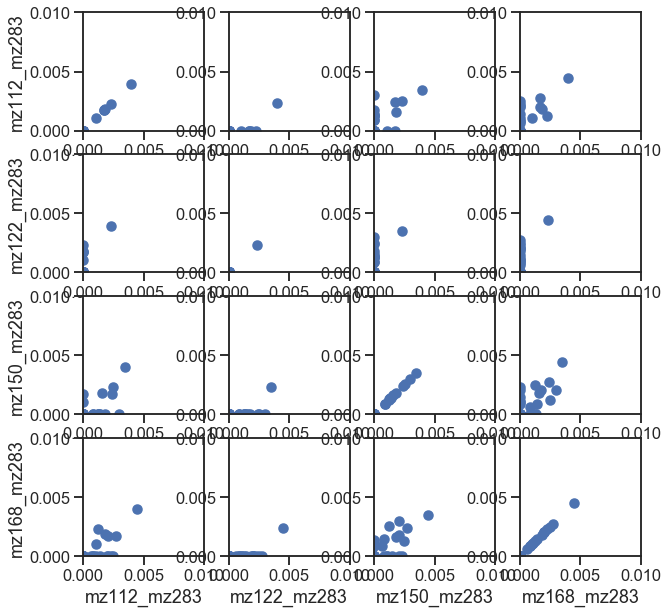

In [24]:
fig, ax = plt.subplots(num_species, num_species, figsize=(10,10))

df_to_plot = df_bd_as_buff[df_bd_as_buff.sol_id == 'bd_ac_001']
for tick in range(num_species):
    y_species = species_names_to_correlate[tick]
    for tock in range(num_species):
        x_species = species_names_to_correlate[tock]
        
        ax[tick, tock].scatter(df_to_plot[y_species], df_to_plot[x_species],
                               label=species)
        ax[tick, tock].set_ylim(ymin=0,ymax=0.01)
        ax[tick, tock].set_xlim(xmin=0,xmax=0.01)
        
        if tick==3:
            ax[tick, tock].set_xlabel(x_species)
    
    ax[tick, 0].set_ylabel(y_species)

# for tick in range(len(nh3)):    
#     title_string = 'nh3 = ' + str(nh3[tick]) + ' millimolal'
#     ax[0, tick].set_title(title_string)
#     ax[5, tick].set_xlabel('time (mins)')

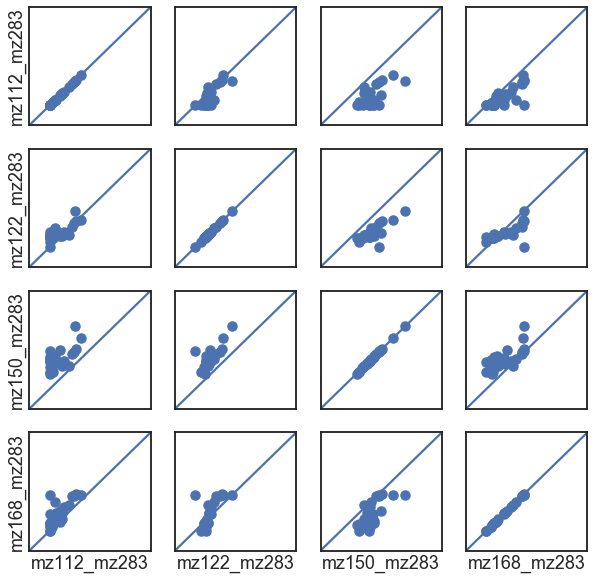

In [25]:
fig, ax = plt.subplots(num_species, num_species, figsize=(10,10))

df_to_plot = df_bd_as_buff[df_bd_as_buff.sol_id == 'bd_ac_002']
for tick in range(num_species):
    y_species = species_names_to_correlate[tick]
    for tock in range(num_species):
        x_species = species_names_to_correlate[tock]
        
        ax[tick, tock].scatter(df_to_plot[x_species], df_to_plot[y_species],
                               label=species)
        ax[tick, tock].set_ylim(ymin=-0.02,ymax=0.1)
        ax[tick, tock].set_xlim(xmin=-0.02,xmax=0.1)
        ax[tick, tock].set_xticks([]) 
        ax[tick, tock].set_yticks([])
        ax[tick, tock].plot(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50))
        
        if tick==3:
            ax[tick, tock].set_xlabel(x_species)
    
    ax[tick, 0].set_ylabel(y_species)

# for tick in range(len(nh3)):    
#     title_string = 'nh3 = ' + str(nh3[tick]) + ' millimolal'
#     ax[0, tick].set_title(title_string)
#     ax[5, tick].set_xlabel('time (mins)')

look at data from the gas experiments

In [37]:
bd_nh3g_expts = load_experiments(['bd_rxn_nh3g_droplet'])
bd_nh3g_expts.keys()

dict_keys(['bd_rxn_nh3g_droplet'])

In [39]:
bd_nh3g_file_name = bd_nh3g_expts['bd_rxn_nh3g_droplet']['paths']['raw_data']
df_bd_nh3g = import_ms_data(bd_nh3g_file_name)
df_bd_nh3g.columns

Index(['Unnamed: 0', 'p149', 'p283', 'p84', 'p85', 'p112', 'p122', 'p150',
       'p168', 'trapped', 'nh3', 'signal_84', 'signal_85', 'signal_149',
       'solution', 'np84', 'np85', 'np149', 'nominal_nh3_mM'],
      dtype='object')

In [42]:
df_bd_nh3g['n112'] = df_bd_nh3g['p112'] / df_bd_nh3g['p283']
df_bd_nh3g['n122'] = df_bd_nh3g['p122'] / df_bd_nh3g['p283']
df_bd_nh3g['n149'] = df_bd_nh3g['p149'] / df_bd_nh3g['p283']
df_bd_nh3g['n150'] = df_bd_nh3g['p150'] / df_bd_nh3g['p283']
df_bd_nh3g['n168'] = df_bd_nh3g['p168'] / df_bd_nh3g['p283']
df_bd_nh3g['n84'] = df_bd_nh3g['np84']
df_bd_nh3g['n85'] = df_bd_nh3g['np85']
df_bd_nh3g['n149'] = df_bd_nh3g['np149']

df_bd_nh3g.columns

Index(['Unnamed: 0', 'p149', 'p283', 'p84', 'p85', 'p112', 'p122', 'p150',
       'p168', 'trapped', 'nh3', 'signal_84', 'signal_85', 'signal_149',
       'solution', 'np84', 'np85', 'np149', 'nominal_nh3_mM', 'n112', 'n122',
       'n149', 'n150', 'n168', 'n84', 'n85'],
      dtype='object')

In [43]:
df_bd_nh3g.nominal_nh3_mM.unique()

array([0.00e+00, 1.45e+03, 1.45e+02, 1.45e+01, 2.90e+00, 5.80e-01])

Text(0.5, 103.49999999999989, 'time (mins)')

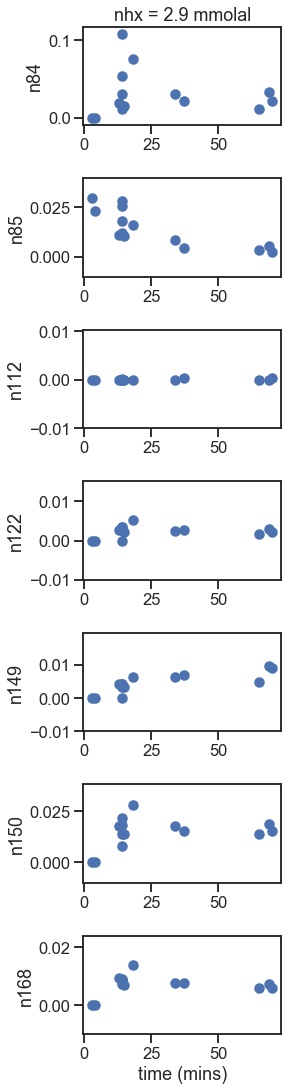

In [48]:
nh3_to_plot = 2.9
species_to_plot = ['n84', 'n85', 'n112', 'n122', 'n149', 'n150', 'n168']
num_species = len(species_to_plot)

fig, ax = plt.subplots(num_species, 1, figsize=(4, 15))
fig.tight_layout()

df_to_plot = df_bd_nh3g[df_bd_nh3g.nominal_nh3_mM == nh3_to_plot]

for tick in range(num_species):
    species = species_to_plot[tick]
    maxval = np.max(df_to_plot[species])
    ax[tick].scatter(df_to_plot.trapped, df_to_plot[species], label=species)
    title_string = 'nhx = ' + str(nh3_to_plot) + ' mmolal'
    ax[tick].set_ylabel(species)
    ax[tick].set_ylim(ymin=-0.01, ymax=maxval+0.01)

ax[0].set_title(title_string)
ax[num_species-1].set_xlabel('time (mins)')

now, repeat the same thing with the ammonium sulfate experiments (probably ph~3?)

In [49]:
bd_as_expts = load_experiments(['bd_rxn_nh42so4_droplet'])
bd_as_expts.keys()

dict_keys(['bd_rxn_nh42so4_droplet'])

In [51]:
bd_as_file_name = bd_as_expts['bd_rxn_nh42so4_droplet']['paths']['raw_data']
df_bd_as = import_ms_data(bd_as_file_name)
df_bd_as.columns

Index(['date', 'file', 'chrom', 'dc_trap', 'mfc', 'src1', 'src2', 'signal',
       'vialstart', 'trapstart', 'eject', 'vial', 'trapped', 'rh', 'comp',
       'wt_frac', 'nh3_bubbler', 'p84', 'p85', 'p112', 'p122', 'p149', 'p150',
       'p168', 'p283', 'note', 'dc_spring', 'ac_spring_f1', 'ac_spring_a1',
       'ac_spring_f2', 'ac_spring_a2', 'dc_spring_after', 'ac_spring_f1_after',
       'ac_spring_a1_after', 'ac_spring_f2_after', 'ac_spring_a2_after',
       'data_path', 'code', 'comptype', 'compnum', 'p84_j', 'p85_j', 'p283_j',
       'n84_j', 'n84', 'n85_j', 'n85', 'bad_data', 'nh3_vial', 'naoh_vial'],
      dtype='object')

In [53]:
df_bd_as['n112'] = df_bd_as['p112'] / df_bd_as['p283']
df_bd_as['n122'] = df_bd_as['p122'] / df_bd_as['p283']
df_bd_as['n149'] = df_bd_as['p149'] / df_bd_as['p283']
df_bd_as['n150'] = df_bd_as['p150'] / df_bd_as['p283']
df_bd_as['n149'] = df_bd_as['p149'] / df_bd_as['p283']
df_bd_as['n168'] = df_bd_as['p168'] / df_bd_as['p283']

df_bd_as.columns

Index(['date', 'file', 'chrom', 'dc_trap', 'mfc', 'src1', 'src2', 'signal',
       'vialstart', 'trapstart', 'eject', 'vial', 'trapped', 'rh', 'comp',
       'wt_frac', 'nh3_bubbler', 'p84', 'p85', 'p112', 'p122', 'p149', 'p150',
       'p168', 'p283', 'note', 'dc_spring', 'ac_spring_f1', 'ac_spring_a1',
       'ac_spring_f2', 'ac_spring_a2', 'dc_spring_after', 'ac_spring_f1_after',
       'ac_spring_a1_after', 'ac_spring_f2_after', 'ac_spring_a2_after',
       'data_path', 'code', 'comptype', 'compnum', 'p84_j', 'p85_j', 'p283_j',
       'n84_j', 'n84', 'n85_j', 'n85', 'bad_data', 'nh3_vial', 'naoh_vial',
       'n112', 'n122', 'n149', 'n150', 'n168'],
      dtype='object')

In [64]:
df_bd_as['n150'].unique()

array([       nan, 0.        , 0.00453354, 0.00393437, 0.00312975,
       0.00318244, 0.00489265, 0.00363537, 0.00273091, 0.00380273])

Text(0.5, 103.49999999999989, 'time (hrs)')

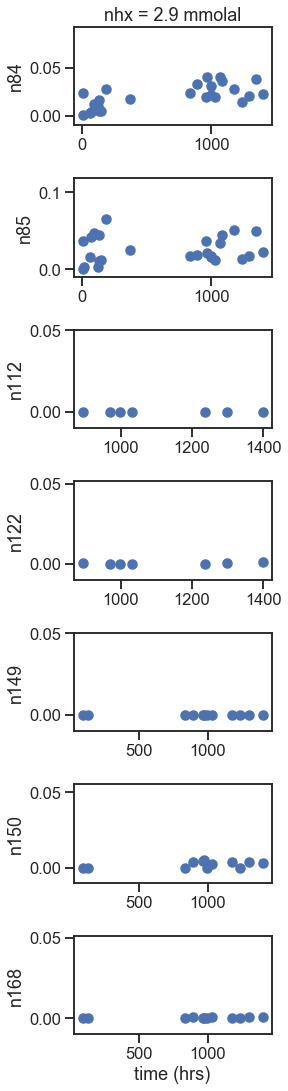

In [67]:
species_to_plot = ['n84', 'n85', 'n112', 'n122', 'n149', 'n150', 'n168']
num_species = len(species_to_plot)

fig, ax = plt.subplots(num_species, 1, figsize=(4, 15))
fig.tight_layout()

df_to_plot = df_bd_as.query('trapped<10 and comptype=="bd07hg20as03"')

for tick in range(num_species):
    species = species_to_plot[tick]
#     maxval = np.nanmax(df_to_plot[species])
    ax[tick].scatter(df_to_plot.vial, df_to_plot[species], label=species)
    title_string = 'nhx = ' + str(nh3_to_plot) + ' mmolal'
    ax[tick].set_ylabel(species)
    ax[tick].set_ylim(ymin=-0.01)

ax[0].set_title(title_string)
ax[num_species-1].set_xlabel('time (hrs)')

